In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import umap

/home/renan/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-30 09:37:41.306500: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 09:37:41.321828: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 09:37:41.419003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 09:37:41.507019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register facto

In [89]:
sumo = {}
sumo_files = os.listdir('data_experiment1_sumo_100Hz')
for file in sumo_files:
    sumo_df = pd.read_csv(f'data_experiment1_sumo_100Hz/{file}')
    sumo_df['gyro_z'] = np.rad2deg(sumo_df['gyro_z'])
    sumo_df = sumo_df.groupby(sumo_df.index // 10).mean() # downsample to 10Hz
    sumo_df['gyro_z'] = ((np.rad2deg(sumo_df['angle']) - np.rad2deg(sumo_df['angle']).shift(1))/10).fillna(0)

    sumo[file.split(".")[0]] = sumo_df
print(sumo.keys())

dict_keys(['veh1_aggressive', 'veh0_normal'])


In [90]:
carla = {}
carla_files = os.listdir('data_experiment1_carla_100Hz')
for file in carla_files:
    carla_df = pd.read_csv(f'data_experiment1_carla_100Hz/{file}')
    carla_df.rename(columns={'latitude': 'y_pos', 'longitude': 'x_pos'}, inplace=True)
    carla_df['acc_z'] -= 9.8
    carla_df['gyro_z'] = np.rad2deg(carla_df['gyro_z'])
    carla_df = carla_df[carla_df['timestamp'] >= 0.005].reset_index(drop=True)
    carla_df = carla_df.groupby(carla_df.index // 10).mean()  # downsample to 10Hz
    carla[file.split('.')[0]] = carla_df
print(carla.keys())

dict_keys(['veh1_aggressive', 'veh0_normal'])


In [91]:
carla['veh0_normal'].head()

,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,compass,y_pos,x_pos
0,0.055,0.000000,0.000000,21.237875,1.106528e-05,-9.691105e-06,1.087463e-06,329.307189,42.01136,2.099285
1,0.155,0.000000,0.000000,7.089750,3.808054e-07,-8.514578e-07,3.369373e-08,329.307189,42.01136,2.099285
2,0.255,0.000000,0.000000,0.624125,-3.019024e-07,2.867668e-07,-5.016023e-09,329.307189,42.01136,2.099285
3,0.355,0.000000,0.000000,-0.609500,-7.571815e-08,1.430337e-07,-5.734805e-09,329.307189,42.01136,2.099285
4,0.455,4.388785,-0.372409,-0.577709,1.912511e-04,-1.537381e-03,8.699236e-02,329.308388,42.01136,2.099285


In [92]:
sumo['veh0_normal'].head()

,timestamp,x_pos,y_pos,speed,speed_x,speed_y,acc,acc_x,acc_y,angle,acc_diff,gyro_z
0,0.055,9486.491454,1291.304549,0.009224,0.006464,-0.006580,0.200918,0.140804,-0.143325,314.491672,2.724565,0.000000e+00
1,0.155,9486.489698,1291.306275,0.039938,0.027989,-0.028490,0.394911,0.276756,-0.281711,314.491672,2.221746,-7.275958e-12
2,0.255,9486.484892,1291.310996,0.094213,0.066025,-0.067207,0.682020,0.477963,-0.486520,314.491672,3.157277,0.000000e+00
3,0.355,9486.474895,1291.320818,0.183910,0.128885,-0.131193,1.089458,0.763499,-0.777168,314.491672,4.544105,1.491571e-11
4,0.455,9486.456753,1291.338640,0.319219,0.223711,-0.227716,1.574198,1.103207,-1.122958,314.491672,4.644607,-2.437446e-11


The time series may have different lengths because of the routing and simulation of each simulator.

In [93]:
for (sumo_k, sumo_v), (carla_k, carla_v) in zip(sumo.items(), carla.items()):
    print(f'Sumo {sumo_k} size: {len(sumo_v)}. Carla {sumo_k} size: {len(carla_v)}')


Sumo veh1_aggressive size: 4540. Carla veh1_aggressive size: 3260
Sumo veh0_normal size: 5042. Carla veh0_normal size: 4074


Note que gyro_z não é obtido diretamente pelo SUMO, aqui está sendo realizada uma aproximação a partir da variação nos ângulos

In [94]:
def plot_df(sumo_df=None, carla_df=None, idx="", uah_df_imu=None, uah_df_gnss=None, save_path=None):
    fig, axes = plt.subplots(4, 2, figsize=(20, 18))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    if sumo_df is not None:
        axes[0].plot(sumo_df['timestamp'], sumo_df['acc_x'], label='Sumo Acc X', alpha=alpha)
    if carla_df is not None:
        axes[0].plot(carla_df['timestamp'], carla_df['acc_x'], label='Carla Acc X', alpha=alpha)
    if uah_df_imu is not None:
        axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    if sumo_df is not None:
        axes[1].plot(sumo_df['timestamp'], sumo_df['acc_y'], label='Sumo Acc Y', alpha=alpha)
    if carla_df is not None:
        axes[1].plot(carla_df['timestamp'], carla_df['acc_y'], label='Carla Acc Y', alpha=alpha)
    if uah_df_imu is not None:
        axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    if sumo_df is not None:
        axes[2].plot(sumo_df['timestamp'], sumo_df['gyro_z'], label='Sumo Gyro Z', alpha=alpha)
    if carla_df is not None:
        axes[2].plot(carla_df['timestamp'], carla_df['gyro_z'], label='Carla Gyro Z', alpha=alpha)
    if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
        axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
    axes[2].set_title("Gyroscope Z over Time")
    axes[2].set_ylabel("Angular Velocity (rad/s)")
    axes[2].legend()
    axes[2].grid(True)

    axes_count = 3
    # Plot angle
    if uah_df_gnss is None:
        if sumo_df is not None:
            axes[axes_count].plot(sumo_df['timestamp'], sumo_df['angle'], label='Sumo Angle', alpha=alpha)
        if carla_df is not None:
            axes[axes_count].plot(carla_df['timestamp'], carla_df['compass'], label='Carla Angle', alpha=alpha)
        if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
            axes[axes_count].plot(uah_df_imu['timestamp'], uah_df_imu['Yaw'], label='UAH Yaw', color='red', alpha=0.7)
        axes[axes_count].set_title("Angle over Time")
        axes[axes_count].set_ylabel("Angle (rad)")
        axes[axes_count].legend()
        axes[axes_count].grid(True)
        axes_count += 1

    # Plot Sumo position
    if sumo_df is not None:
        scatter = axes[axes_count].scatter(sumo_df['x_pos'], sumo_df['y_pos'], c=sumo_df['timestamp'], cmap='viridis', s=10, label='Sumo')
        axes[axes_count].set_title("Sumo Position over Time")
        axes[axes_count].set_xlabel("X position")
        axes[axes_count].set_ylabel("Y position")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Plot Carla position
    if carla_df is not None:
        scatter = axes[axes_count].scatter(carla_df['x_pos'], carla_df['y_pos'], c=carla_df['timestamp'], cmap='viridis', s=10, label='Carla')
        axes[axes_count].set_title("Carla Position over Time")
        axes[axes_count].set_xlabel("X position")
        axes[axes_count].set_ylabel("Y position")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Plot UAH position if available
    if uah_df_gnss is not None and 'lat' in uah_df_gnss.columns and 'lon' in uah_df_gnss.columns and 'timestamp' in uah_df_gnss.columns:
        scatter = axes[axes_count].scatter(uah_df_gnss['lon'], uah_df_gnss['lat'], c=uah_df_gnss['timestamp'], cmap='viridis', s=10, label='UAH', alpha=0.7)
        axes[axes_count].set_title("UAH Position over Time")
        axes[axes_count].set_xlabel("Longitude")
        axes[axes_count].set_ylabel("Latitude")
        axes[axes_count].grid(True)
        cbar = fig.colorbar(scatter, ax=axes[axes_count])
        cbar.set_label("Time (s)")
        axes_count += 1

    # Remove unused axes if any
    if axes_count < 8:
        for i in range(axes_count, 8):
            fig.delaxes(axes[i])

    fig.tight_layout(rect=[0, 0.03, 1, 0.96])

    if uah_df_imu is not None:
        if carla_df is not None:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO, CARLA, and UAH Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'Comparison of CARLA and UAH Data for {idx}', fontsize=18)
        else:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO and UAH Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'UAH Data for {idx}', fontsize=18)
    else:
        if carla_df is not None:
            if sumo_df is not None:
                fig.suptitle(f'Comparison of SUMO and CARLA Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'CARLA Data for {idx}', fontsize=18)
        else:
            if sumo_df is not None:
                fig.suptitle(f'SUMO Data for {idx}', fontsize=18)
            else:
                fig.suptitle(f'No data available for {idx}', fontsize=18)
    
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [95]:
def plot_histograms(sumo_df, carla_df, idx, uah_df_imu = None, bins=50, save_path=None):
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    axes = axes.flatten()

    # Plot acceleration X
    axes[0].hist(sumo_df['acc_x'], bins=bins, alpha=0.5, label='Sumo Acc X', density=True, color='blue')
    axes[0].hist(carla_df['acc_x'], bins=bins, alpha=0.5, label='Carla Acc X', density=True, color='orange')
    sumo_df['acc_x'].plot(kind='kde', ax=axes[0], label='Sumo Acc X KDE', color='blue')
    carla_df['acc_x'].plot(kind='kde', ax=axes[0], label='Carla Acc X KDE', color='orange')
    if uah_df_imu is not None and 'acc_x' in uah_df_imu.columns:
        axes[0].hist(uah_df_imu['acc_x'], bins=bins, alpha=0.5, label='UAH Acc X', density=True, color='green')
        uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].hist(sumo_df['acc_y'], bins=bins, alpha=0.5, label='Sumo Acc Y', density=True, color='blue')
    axes[1].hist(carla_df['acc_y'], bins=bins, alpha=0.5, label='Carla Acc Y', density=True, color='orange')
    sumo_df['acc_y'].plot(kind='kde', ax=axes[1], label='Sumo Acc Y KDE', color='blue')
    carla_df['acc_y'].plot(kind='kde', ax=axes[1], label='Carla Acc Y KDE', color='orange')
    if uah_df_imu is not None and 'acc_y' in uah_df_imu.columns:
        axes[1].hist(uah_df_imu['acc_y'], bins=bins, alpha=0.5, label='UAH Acc Y', density=True, color='green')
        uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].hist(sumo_df['gyro_z'], bins=bins, alpha=0.5, label='Sumo Gyro Z', density=True, color='blue')
    axes[2].hist(carla_df['gyro_z'], bins=bins, alpha=0.5, label='Carla Gyro Z', density=True, color='orange')
    sumo_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Sumo Gyro Z KDE', color='blue')
    carla_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Carla Gyro Z KDE', color='orange')
    if uah_df_imu is not None and 'Yaw' in uah_df_imu.columns:
        axes[2].hist(uah_df_imu['Yaw'], bins=bins, alpha=0.5, label='UAH Yaw', density=True, color='green')
        uah_df_imu['Yaw'].plot(kind='kde', ax=axes[2], label='UAH Yaw KDE', color='green')
    axes[2].set_title("Gyroscope Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    # Plot angle
    axes[3].hist(sumo_df['angle'], bins=bins, alpha=0.5, label='Sumo Angle', density=True, color='blue')
    axes[3].hist(carla_df['compass'], bins=bins, alpha=0.5, label='Carla Angle', density=True, color='orange')
    sumo_df['angle'].plot(kind='kde', ax=axes[3], label='Sumo Angle KDE', color='blue')
    carla_df['compass'].plot(kind='kde', ax=axes[3], label='Carla Angle KDE', color='orange')
    axes[3].set_title("Angle Histogram")
    axes[3].set_ylabel("Density")
    axes[3].legend()
    axes[3].grid(True)

    # Set the main title
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])  # Leave space at the top for suptitle
    fig.suptitle(f'Histogram Comparison of SUMO, CARLA, and UAH Data for {idx}', fontsize=18)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


## UAH-Driveset

In [96]:
def getData(driver, specifier, sensor):

    if sensor == 'acc':
        for i in os.listdir(f'UAH-DRIVESET-v1/{driver}'):
            if i.endswith(specifier):
                data = pd.read_csv(f'UAH-DRIVESET-v1/{driver}/{i}/RAW_ACCELEROMETERS.txt', sep=' ', header=None, names=[
                    'timestamp',
                    'system_active',
                    'acc_x',
                    'acc_y',
                    'acc_z',
                    'acc_x_KF',
                    'acc_y_KF',
                    'acc_z_KF',
                    'Roll',
                    'Pitch',
                    'Yaw'
                ], usecols=range(11))
                data = data.drop(['system_active'], axis=1)
                data['acc'] = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
                return data
            
    elif sensor == 'gps':
        for i in os.listdir(f'UAH-DRIVESET-v1/{driver}'):
            if i.endswith(specifier):
                data = pd.read_csv(f'UAH-DRIVESET-v1/{driver}/{i}/RAW_GPS.txt', sep=' ', header=None, names=[
                    'timestamp',
                    'speed',
                    'lat',
                    'lon',
                    'altitude',
                    'vert_accuracy',
                    'horiz_accuracy',
                    'course',
                    'difcourse',
                ], usecols=range(9))
                return data

In [97]:
def read_gps(drivers):
    normal = pd.DataFrame()
    aggressive = pd.DataFrame()
    drowsy = pd.DataFrame()
    for driver in drivers:
        normal = pd.concat([normal, getData(driver, 'NORMAL1-SECONDARY', sensor='gps')], axis=0)
        # normal = pd.concat([normal, getData(driver, 'NORMAL2-SECONDARY', sensor='gps')], axis=0)
        aggressive = pd.concat([aggressive, getData(driver, 'AGGRESSIVE-SECONDARY', sensor='gps')], axis=0)
        drowsy = pd.concat([drowsy, getData(driver, 'DROWSY-SECONDARY', sensor='gps')], axis=0)

    df_gps = {}
    df_gps['normal'] = normal
    df_gps['aggressive'] = aggressive
    df_gps['drowsy'] = drowsy

    return df_gps

In [98]:
def read_accelerometer(drivers):
    normal = pd.DataFrame()
    aggressive = pd.DataFrame()
    drowsy = pd.DataFrame()
    for driver in drivers:
        normal = pd.concat([normal, getData(driver, 'NORMAL1-SECONDARY', sensor='acc')], axis=0)
        # normal = pd.concat([normal, getData(driver, 'NORMAL2-SECONDARY', sensor='acc')], axis=0)
        aggressive = pd.concat([aggressive, getData(driver, 'AGGRESSIVE-SECONDARY', sensor='acc')], axis=0)
        drowsy = pd.concat([drowsy, getData(driver, 'DROWSY-SECONDARY', sensor='acc')], axis=0)

    df_accelerometer = {}
    df_accelerometer['normal'] = normal
    df_accelerometer['aggressive'] = aggressive
    df_accelerometer['drowsy'] = drowsy

    return df_accelerometer

Reading from only one driver and one run to be able to compare

In [99]:
drivers = ['D1']

In [100]:
df_acc = read_accelerometer(drivers)
df_gps = read_gps(drivers)

In [101]:
df_gps['normal']

,timestamp,speed,lat,lon,altitude,vert_accuracy,horiz_accuracy,course,difcourse
0,7.85,65.2,40.512787,-3.404477,612.7,4,5,331.9,0.000
1,8.83,64.5,40.512924,-3.404577,612.5,4,5,331.9,0.000
2,9.82,63.6,40.513065,-3.404680,612.9,4,5,330.8,1.055
3,10.80,62.2,40.513210,-3.404772,613.3,4,5,330.8,1.055
4,11.80,60.9,40.513348,-3.404868,613.5,3,5,330.1,0.703
...,...,...,...,...,...,...,...,...,...
619,626.80,92.0,40.584282,-3.552518,610.6,6,5,282.3,3.164
620,627.82,90.8,40.584324,-3.552810,610.2,6,5,281.2,2.812
621,628.82,89.7,40.584354,-3.553110,610.0,6,5,279.8,2.461
622,629.82,88.7,40.584393,-3.553401,609.7,6,5,278.4,2.812


In [102]:
df_acc['normal'] = df_acc['normal'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})
df_acc['aggressive'] = df_acc['aggressive'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})

In [103]:
df_acc['normal'].head()

,timestamp,acc_z,acc_y,acc_x,acc_x_KF,acc_y_KF,acc_z_KF,Roll,Pitch,gyro_z,acc
0,6.94,0.017,-0.011,0.018,-0.005,0.008,0.018,-1.523,0.015,0.012,0.027092
1,7.03,0.046,0.007,0.019,0.016,-0.002,0.018,-1.522,0.012,0.012,0.050259
2,7.14,0.052,-0.016,0.027,0.037,-0.005,0.018,-1.520,0.014,0.011,0.060737
3,7.24,0.015,-0.016,0.026,0.038,-0.009,0.024,-1.523,0.014,0.011,0.034015
4,7.34,-0.014,-0.017,0.040,0.012,-0.016,0.032,-1.525,0.012,0.011,0.045662


Simulated only up to lat, lon = 40.554174, -3.497402 because of simulation problems. Let's trim the dataset in this position

In [104]:
def trim_gnss(df_gnss, df_acc, lat, lon, lat_margin=0.001, lon_margin=0.001):

    # Define bounds
    lat_min = lat - lat_margin
    lat_max = lat + lat_margin
    lon_min = lon - lon_margin
    lon_max = lon + lon_margin

    # Find the first index within the interval
    condition = (
        (df_gnss['lat'] >= lat_min) & (df_gnss['lat'] <= lat_max) &
        (df_gnss['lon'] >= lon_min) & (df_gnss['lon'] <= lon_max)
    )

    # Get the first matching index
    matching_indices = df_gnss.index[condition]

    if not matching_indices.empty:
        timestamp = df_gnss['timestamp'].iloc[matching_indices[0]]
        closest_idx = matching_indices[0]
        print(f"Trimming GNSS data to timestamp: {timestamp}")
        gnss_trimmed = df_gnss.loc[closest_idx:].copy()
        print(f"Trimming accelerometer data to timestamp: {timestamp}")
        acc_trimmed = df_acc[df_acc['timestamp'] >= timestamp]
        acc_trimmed['timestamp'] -= timestamp
        gnss_trimmed['timestamp'] -= timestamp
        return gnss_trimmed, acc_trimmed

    else:
        raise ValueError("No matching GNSS data found within the specified bounds.")

In [105]:
max_lat, max_lon = 40.534921, -3.468994
# Find all rows where lat and lon are within a small range of max_lat and max_lon
df_gps['normal'], df_acc['normal'] = trim_gnss(df_gps['normal'], df_acc['normal'], max_lat, max_lon, lat_margin=0.001, lon_margin=0.001)
df_gps['aggressive'], df_acc['aggressive'] = trim_gnss(df_gps['aggressive'], df_acc['aggressive'], max_lat, max_lon, lat_margin=0.001, lon_margin=0.001)

Trimming GNSS data to timestamp: 258.83
Trimming accelerometer data to timestamp: 258.83
Trimming GNSS data to timestamp: 200.19
Trimming accelerometer data to timestamp: 200.19


/tmp/ipykernel_9611/489965173.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_trimmed['timestamp'] -= timestamp


In [106]:
mean_normal = df_gps['normal']['speed'].mean()
max_normal = df_gps['normal']['speed'].max()
mean_aggressive = df_gps['aggressive']['speed'].mean()
max_aggressive = df_gps['aggressive']['speed'].max()

print(f"Normal:    Mean speed = {mean_normal:.2f} km/h, Max speed = {max_normal:.2f} km/h")
print(f"Aggressive: Mean speed = {mean_aggressive:.2f} km/h, Max speed = {max_aggressive:.2f} km/h")

# Convert to m/s (1 km/h = 0.27778 m/s)
mean_normal_ms = mean_normal * 0.27778
max_normal_ms = max_normal * 0.27778
mean_aggressive_ms = mean_aggressive * 0.27778
max_aggressive_ms = max_aggressive * 0.27778

print(f"Normal:    Mean speed = {mean_normal_ms:.2f} m/s, Max speed = {max_normal_ms:.2f} m/s")
print(f"Aggressive: Mean speed = {mean_aggressive_ms:.2f} m/s, Max speed = {max_aggressive_ms:.2f} m/s")


Normal:    Mean speed = 98.60 km/h, Max speed = 114.90 km/h
Aggressive: Mean speed = 111.36 km/h, Max speed = 132.70 km/h
Normal:    Mean speed = 27.39 m/s, Max speed = 31.92 m/s
Aggressive: Mean speed = 30.93 m/s, Max speed = 36.86 m/s


In [107]:
# Getting a second real driver to compare with
df_acc_2 = read_accelerometer(['D3'])
df_gps_2 = read_gps(['D3'])
# Find all rows where lat and lon are within a small range of max_lat and max_lon
df_gps_2['normal'], df_acc_2['normal'] = trim_gnss(df_gps_2['normal'], df_acc_2['normal'], max_lat, max_lon, lat_margin=0.0005, lon_margin=0.0005)
df_gps_2['aggressive'], df_acc_2['aggressive'] = trim_gnss(df_gps_2['aggressive'], df_acc_2['aggressive'], max_lat, max_lon, lat_margin=0.001, lon_margin=0.001)

Trimming GNSS data to timestamp: 261.93
Trimming accelerometer data to timestamp: 261.93
Trimming GNSS data to timestamp: 236.91
Trimming accelerometer data to timestamp: 236.91


/tmp/ipykernel_9611/489965173.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_trimmed['timestamp'] -= timestamp


In [71]:
df_acc_2['normal'] = df_acc_2['normal'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})
df_acc_2['aggressive'] = df_acc_2['aggressive'].rename(columns={
    'acc_x': 'acc_z',
    'acc_y': 'acc_y',
    'acc_z': 'acc_x',
    'Yaw': 'gyro_z',
    'timestamp': 'timestamp'
})

In [108]:
def plot_gps(df_gps, sumo_df=None, carla_df=None, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))

    # Plot UAH GPS
    axes[0].scatter(df_gps['lon'], df_gps['lat'], c=df_gps['timestamp'], cmap='viridis', s=10)
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].set_title("UAH Position")
    cbar0 = fig.colorbar(axes[0].collections[0], ax=axes[0])
    cbar0.set_label("Time (s)")
    axes[0].grid(True)

    # Plot SUMO
    if sumo_df is not None:
        axes[1].scatter(sumo_df['x_pos'], sumo_df['y_pos'], c=sumo_df['timestamp'], cmap='viridis', s=10)
        axes[1].set_xlabel("X position")
        axes[1].set_ylabel("Y position")
        axes[1].set_title("SUMO Position")
        cbar1 = fig.colorbar(axes[1].collections[0], ax=axes[1])
        cbar1.set_label("Time (s)")
        axes[1].grid(True)

    # Plot CARLA
    if carla_df is not None:
        axes[2].scatter(carla_df['x_pos'], carla_df['y_pos'], c=carla_df['timestamp'], cmap='viridis', s=10)
        axes[2].set_xlabel("X position")
        axes[2].set_ylabel("Y position")
        axes[2].set_title("CARLA Position")
        cbar2 = fig.colorbar(axes[2].collections[0], ax=axes[2])
        cbar2.set_label("Time (s)")
        axes[2].grid(True)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)

    plt.tight_layout()
    plt.show()

In [109]:
def plot_gyro_z(df_acc, sumo_df, carla_df):
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))

    # Plot Gyro Z
    axes.plot(carla_df['timestamp'], carla_df['gyro_z'], label='CARLA Gyro Z', color='green', alpha=0.7)
    axes.plot(sumo_df['timestamp'], sumo_df['gyro_z'], label='SUMO Gyro Z', color='blue', alpha=0.7) 
    axes.plot(df_acc['timestamp'], df_acc['gyro_z'], label='UAH Gyro Z', color='red')
    axes.set_title("Gyro Z over Time")
    axes.set_xlabel("Time (s)")
    axes.set_ylabel("Gyro Z (rad/s)")
    axes.grid(True)
    axes.legend()

    plt.tight_layout()
    plt.show()

In [110]:
def plot_angle(df_gps, sumo_df, carla_df):
    plt.plot(df_gps['timestamp'], df_gps['course'], label='UAH Course', color='red', alpha=0.7)
    if sumo_df is not None:
        plt.plot(sumo_df['timestamp'], sumo_df['angle'], label='SUMO Angle', color='blue', alpha=0.7)
    if carla_df is not None:
        plt.plot(carla_df['timestamp'], carla_df['compass'], label='CARLA Compass', color='green', alpha=0.7)
    plt.legend()
    plt.grid()
    plt.show()

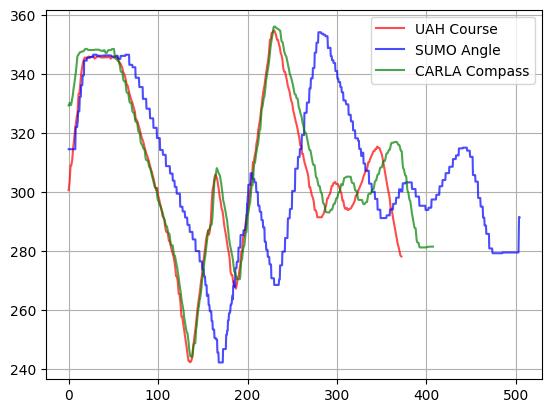

In [111]:
plot_angle(df_gps['normal'], sumo['veh0_normal'], carla['veh0_normal'])

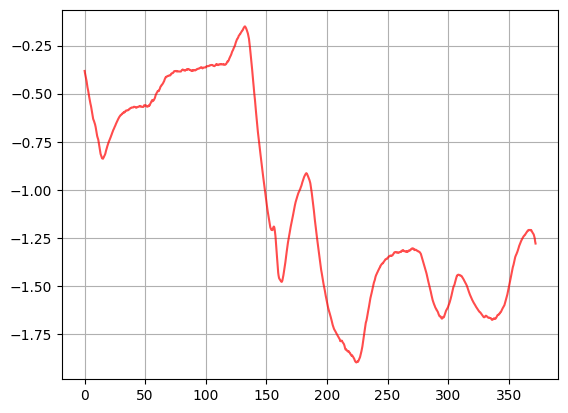

In [146]:
plt.plot(df_acc['normal']['timestamp'], df_acc['normal']['gyro_z'], label='UAH Acc X', color='red', alpha=0.7)
plt.grid()

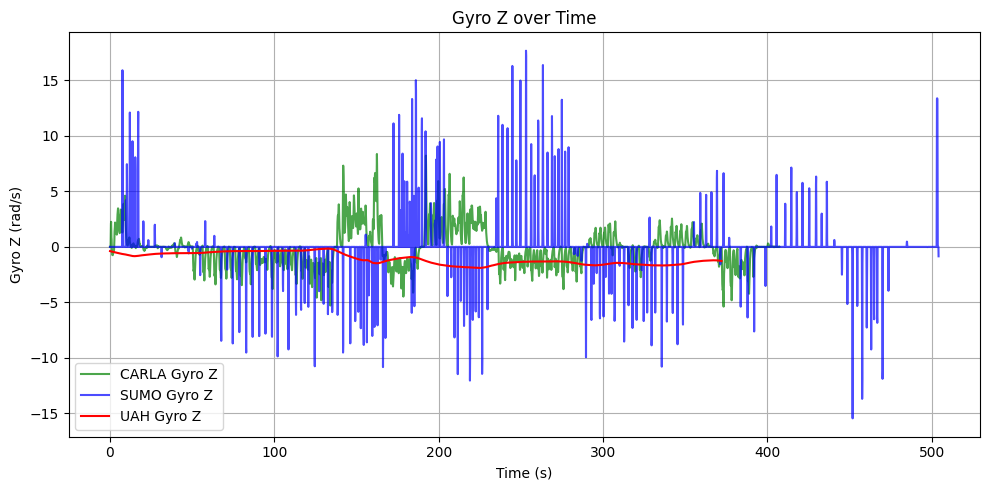

In [113]:
plot_gyro_z(df_acc['normal'], sumo['veh0_normal'], carla['veh0_normal'])

In [114]:
plot_gps(df_gps['normal'], sumo['veh0_normal'], carla['veh0_normal'], save_path='gps_positions.png')  

<Figure size 640x480 with 0 Axes>

In [115]:
def plot_sim_uah(sumo_df, uah_df_gnss, uah_df_imu, idx, sim_name, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes = axes.flatten()
    alpha = 0.6

    if sim_name == 'SUMO':
        color = 'darkgoldenrod'
    else:
        color = 'blue'

    # Plot acceleration X
    axes[0].plot(sumo_df['timestamp'], sumo_df['acc_x'], label='Sumo Acc X', alpha=alpha, color=color)
    axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(sumo_df['timestamp'], sumo_df['acc_y'], label='Sumo Acc Y', alpha=alpha, color=color)
    axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].plot(sumo_df['timestamp'], sumo_df['gyro_z'], label='Sumo Gyro Z', alpha=alpha, color=color)
    axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['gyro_z'], label='UAH Gyro Z', color='red', alpha=0.7)
    axes[2].set_title("Gyroscope Z over Time")
    axes[2].set_ylabel("Angular Velocity (rad/s)")
    axes[2].legend()
    axes[2].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])
    
    fig.suptitle(f'Comparison of {sim_name} and UAH Data data for {idx.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [116]:
def plot_carla_uah(carla_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    # Plot acceleration X
    axes[0].plot(carla_df['timestamp'], carla_df['acc_x'], label='Carla Acc X', alpha=alpha)
    axes[0].plot(uah_df_imu['timestamp'], uah_df_imu['acc_x'], label='UAH Acc X', color='red', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(carla_df['timestamp'], carla_df['acc_y'], label='Carla Acc Y', alpha=alpha)
    axes[1].plot(uah_df_imu['timestamp'], uah_df_imu['acc_y'], label='UAH Acc Y', color='red', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot acceleration Z
    axes[2].plot(carla_df['timestamp'], carla_df['acc_z'], label='Carla Acc Z', alpha=alpha)
    axes[2].plot(uah_df_imu['timestamp'], uah_df_imu['acc_z'], label='UAH Acc Z', color='red', alpha=0.7)
    axes[2].set_title("Acceleration Z over Time")
    axes[2].set_ylabel("Acceleration (m/s²)")
    axes[2].legend()
    axes[2].grid(True)

    # Plot gyroscope X
    axes[3].plot(carla_df['timestamp'], carla_df['gyro_x'], label='Carla Gyro X', alpha=alpha)
    axes[3].plot(uah_df_imu['timestamp'], uah_df_imu['Roll'], label='UAH Roll', color='red', alpha=0.7)
    axes[3].set_title("Gyroscope X over Time")
    axes[3].set_ylabel("Angular Velocity (rad/s)")
    axes[3].legend()
    axes[3].grid(True)

    # Plot gyroscope Y
    axes[4].plot(carla_df['timestamp'], carla_df['gyro_y'], label='Carla Gyro Y', alpha=alpha)
    axes[4].plot(uah_df_imu['timestamp'], uah_df_imu['Pitch'], label='UAH Pitch', color='red', alpha=0.7)
    axes[4].set_title("Gyroscope Y over Time")
    axes[4].set_ylabel("Angular Velocity (rad/s)")
    axes[4].legend()
    axes[4].grid(True)

    # Plot gyroscope Z
    axes[5].plot(carla_df['timestamp'], carla_df['gyro_z'], label='Carla Gyro Z', alpha=alpha)
    axes[5].plot(uah_df_imu['timestamp'], uah_df_imu['gyro_z'], label='UAH Gyro Z', color='red', alpha=0.7)
    axes[5].set_title("Gyroscope Z over Time")
    axes[5].set_ylabel("Angular Velocity (rad/s)")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of CARLA and UAH Data for {veh.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [117]:
def plot_uah_uah(uah_imu1, uah_imu2, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    uah_imu1 = uah_imu1.rename(columns={'gyro_x': 'Roll', 'gyro_y': 'Pitch', 'gyro_z': 'Yaw'})
    uah_imu2 = uah_imu2.rename(columns={'gyro_x': 'Roll', 'gyro_y': 'Pitch', 'gyro_z': 'Yaw'})

    # Plot acceleration X
    axes[0].plot(uah_imu1['timestamp'], uah_imu1['acc_x'], label='UAH_D1 Acc X', alpha=alpha, color='red')
    axes[0].plot(uah_imu2['timestamp'], uah_imu2['acc_x'], label='UAH_D2 Acc X', color='green', alpha=0.7)
    axes[0].set_title("Acceleration X over Time")
    axes[0].set_ylabel("Acceleration (m/s²)")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].plot(uah_imu1['timestamp'], uah_imu1['acc_y'], label='UAH_D1 Acc Y', alpha=alpha, color='red')
    axes[1].plot(uah_imu2['timestamp'], uah_imu2['acc_y'], label='UAH_D2 Acc Y', color='green', alpha=0.7)
    axes[1].set_title("Acceleration Y over Time")
    axes[1].set_ylabel("Acceleration (m/s²)")
    axes[1].legend()
    axes[1].grid(True)

    # Plot acceleration Z
    axes[2].plot(uah_imu1['timestamp'], uah_imu1['acc_z'], label='UAH_D1 Acc Z', alpha=alpha, color='red')
    axes[2].plot(uah_imu2['timestamp'], uah_imu2['acc_z'], label='UAH_D2 Acc Z', color='green', alpha=0.7)
    axes[2].set_title("Acceleration Z over Time")
    axes[2].set_ylabel("Acceleration (m/s²)")
    axes[2].legend()
    axes[2].grid(True)

    # Plot gyroscope X
    axes[3].plot(uah_imu1['timestamp'], uah_imu1['Roll'], label='UAH_D1 Roll', alpha=alpha, color='red')
    axes[3].plot(uah_imu2['timestamp'], uah_imu2['Roll'], label='UAH_D2 Roll', color='green', alpha=0.7)
    axes[3].set_title("Gyroscope X over Time")
    axes[3].set_ylabel("Angular Velocity (rad/s)")
    axes[3].legend()
    axes[3].grid(True)

    # Plot gyroscope Y
    axes[4].plot(uah_imu1['timestamp'], uah_imu1['Pitch'], label='UAH_D1 Pitch', alpha=alpha, color='red')
    axes[4].plot(uah_imu2['timestamp'], uah_imu2['Pitch'], label='UAH_D2 Pitch', color='green', alpha=0.7)
    axes[4].set_title("Gyroscope Y over Time")
    axes[4].set_ylabel("Angular Velocity (rad/s)")
    axes[4].legend()
    axes[4].grid(True)

    # Plot gyroscope Z
    axes[5].plot(uah_imu1['timestamp'], uah_imu1['Yaw'], label='UAH_D1 Yaw', alpha=alpha, color='red')
    axes[5].plot(uah_imu2['timestamp'], uah_imu2['Yaw'], label='UAH_D2 Yaw', color='green', alpha=0.7)
    axes[5].set_title("Gyroscope Z over Time")
    axes[5].set_ylabel("Angular Velocity (rad/s)")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of UAH for driver 1 and driver 2', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [118]:
def hist_sim_uah(sumo_df, uah_df_imu, uah_df_gnss, idx, sim_name, save_path=None):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes = axes.flatten()

    if sim_name == 'SUMO':
        color = 'darkgoldenrod'
    else:
        color = 'blue'

    # Plot acceleration X
    axes[0].hist(sumo_df['acc_x'], bins=50, alpha=0.5, label='Sumo Acc X', density=True, color=color)
    axes[0].hist(uah_df_imu['acc_x'], bins=50, alpha=0.5, label='UAH Acc X', density=True, color='red')
    sumo_df['acc_x'].plot(kind='kde', ax=axes[0], label='Sumo Acc X KDE', color=color)
    uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='red')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Plot acceleration Y
    axes[1].hist(sumo_df['acc_y'], bins=50, alpha=0.5, label='Sumo Acc Y', density=True, color=color)
    axes[1].hist(uah_df_imu['acc_y'], bins=50, alpha=0.5, label='UAH Acc Y', density=True, color='red')
    sumo_df['acc_y'].plot(kind='kde', ax=axes[1], label='Sumo Acc Y KDE', color=color)
    uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='red')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Plot gyroscope Z
    axes[2].hist(sumo_df['gyro_z'], bins=50, alpha=0.5, label='Sumo Gyro Z', density=True, color=color)
    axes[2].hist(uah_df_imu['gyro_z'], bins=50, alpha=0.5, label='UAH Gyro Z', density=True, color='red')
    sumo_df['gyro_z'].plot(kind='kde', ax=axes[2], label='Sumo Gyro Z KDE', color=color)
    uah_df_imu['gyro_z'].plot(kind='kde', ax=axes[2], label='UAH Gyro Z KDE', color='red')
    axes[2].set_title("Gyroscope Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])  # Leave space at the top for suptitle
    fig.suptitle(f'Histogram Comparison of {sim_name} and UAH Data for {idx.split("_")[-1]} vehicle', fontsize=16)
    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [119]:
def hist_carla_uah(carla_df, uah_df_imu, uah_df_gnss, veh, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    alpha = 0.6

    # Acceleration X histogram
    axes[0].hist(carla_df['acc_x'], bins=50, alpha=0.5, label='Carla Acc X', density=True, color='blue')
    axes[0].hist(uah_df_imu['acc_x'], bins=50, alpha=0.5, label='UAH Acc X', density=True, color='green')
    carla_df['acc_x'].plot(kind='kde', ax=axes[0], label='Carla Acc X KDE', color='blue')
    uah_df_imu['acc_x'].plot(kind='kde', ax=axes[0], label='UAH Acc X KDE', color='green')
    axes[0].set_title("Acceleration X Histogram")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].grid(True)

    # Acceleration Y histogram
    axes[1].hist(carla_df['acc_y'], bins=50, alpha=0.5, label='Carla Acc Y', density=True, color='blue')
    axes[1].hist(uah_df_imu['acc_y'], bins=50, alpha=0.5, label='UAH Acc Y', density=True, color='green')
    carla_df['acc_y'].plot(kind='kde', ax=axes[1], label='Carla Acc Y KDE', color='blue')
    uah_df_imu['acc_y'].plot(kind='kde', ax=axes[1], label='UAH Acc Y KDE', color='green')
    axes[1].set_title("Acceleration Y Histogram")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].grid(True)

    # Acceleration Z histogram
    axes[2].hist(carla_df['acc_z'], bins=50, alpha=0.5, label='Carla Acc Z', density=True, color='blue')
    axes[2].hist(uah_df_imu['acc_z'], bins=50, alpha=0.5, label='UAH Acc Z', density=True, color='green')
    carla_df['acc_z'].plot(kind='kde', ax=axes[2], label='Carla Acc Z KDE', color='blue')
    uah_df_imu['acc_z'].plot(kind='kde', ax=axes[2], label='UAH Acc Z KDE', color='green')
    axes[2].set_title("Acceleration Z Histogram")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].grid(True)

    # Gyroscope X histogram
    axes[3].hist(carla_df['gyro_x'], bins=50, alpha=0.5, label='Carla Gyro X', density=True, color='blue')
    axes[3].hist(uah_df_imu['Roll'], bins=50, alpha=0.5, label='UAH Roll', density=True, color='green')
    carla_df['gyro_x'].plot(kind='kde', ax=axes[3], label='Carla Gyro X KDE', color='blue')
    uah_df_imu['Roll'].plot(kind='kde', ax=axes[3], label='UAH Roll KDE', color='green')
    axes[3].set_title("Gyroscope X Histogram")
    axes[3].set_ylabel("Density")
    axes[3].legend()
    axes[3].grid(True)

    # Gyroscope Y histogram
    axes[4].hist(carla_df['gyro_y'], bins=50, alpha=0.5, label='Carla Gyro Y', density=True, color='blue')
    axes[4].hist(uah_df_imu['Pitch'], bins=50, alpha=0.5, label='UAH Pitch', density=True, color='green')
    carla_df['gyro_y'].plot(kind='kde', ax=axes[4], label='Carla Gyro Y KDE', color='blue')
    uah_df_imu['Pitch'].plot(kind='kde', ax=axes[4], label='UAH Pitch KDE', color='green')
    axes[4].set_title("Gyroscope Y Histogram")
    axes[4].set_ylabel("Density")
    axes[4].legend()
    axes[4].grid(True)

    # Gyroscope Z histogram
    axes[5].hist(carla_df['gyro_z'], bins=50, alpha=0.5, label='Carla Gyro Z', density=True, color='blue')
    axes[5].hist(uah_df_imu['gyro_z'], bins=50, alpha=0.5, label='UAH Gyro Z', density=True, color='green')
    carla_df['gyro_z'].plot(kind='kde', ax=axes[5], label='Carla Gyro Z KDE', color='blue')
    uah_df_imu['gyro_z'].plot(kind='kde', ax=axes[5], label='UAH Gyro Z KDE', color='green')
    axes[5].set_title("Gyroscope Z Histogram")
    axes[5].set_ylabel("Density")
    axes[5].legend()
    axes[5].grid(True)

    fig.tight_layout(rect=[0, 0.03, 1, 0.94])

    fig.suptitle(f'Comparison of CARLA and UAH Data for {veh.split('_')[-1]} vehicle', fontsize=16)

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [120]:
os.makedirs('plots_hist', exist_ok=True)
os.makedirs('plots_uah', exist_ok=True)
for id in carla.keys():
    if id.split('_')[1] == 'normal':
        plot_sim_uah(carla[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], idx=id, sim_name='CARLA', save_path=f'plots_uah/carla_{id}.png')
        hist_sim_uah(carla[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], idx=id, sim_name='CARLA', save_path=f'plots_hist/carla_{id}.png')
    else:
        plot_sim_uah(carla[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], idx=id, sim_name='CARLA', save_path=f'plots_uah/carla_{id}.png')
        hist_sim_uah(carla[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], idx=id, sim_name='CARLA', save_path=f'plots_hist/carla_{id}.png')

In [121]:
for id in sumo.keys():
    if id.split('_')[1] == 'normal':
        plot_sim_uah(sumo[id], uah_df_gnss=df_gps['normal'], uah_df_imu=df_acc['normal'], idx=id, sim_name='SUMO', save_path=f'plots_uah/sumo_{id}.png')
        hist_sim_uah(sumo[id], uah_df_imu=df_acc['normal'], uah_df_gnss=df_gps['normal'], idx=id, sim_name='SUMO', save_path=f'plots_hist/sumo_{id}.png')
    else:
        plot_sim_uah(sumo[id], uah_df_gnss=df_gps['aggressive'], uah_df_imu=df_acc['aggressive'], idx=id, sim_name='SUMO', save_path=f'plots_uah/sumo_{id}.png')
        hist_sim_uah(sumo[id], uah_df_imu=df_acc['aggressive'], uah_df_gnss=df_gps['aggressive'], idx=id, sim_name='SUMO', save_path=f'plots_hist/sumo_{id}.png')

In [122]:
for beh in ['normal', 'aggressive']:
    plot_uah_uah(uah_imu1=df_acc[beh], uah_imu2=df_acc_2[beh], save_path=f'plots_uah/uah_uah_{beh}.png')

# Comparison Metrics

In [123]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon

In [124]:
def compare_distributions(carla_data, sumo_data, bins=100):
    # Define common bin edges
    min_val = min(carla_data.min(), sumo_data.min())
    max_val = max(carla_data.max(), sumo_data.max())
    hist_bins = np.linspace(min_val, max_val, bins + 1)

    # Histogram with density=True to approximate PDFs
    carla_hist, _ = np.histogram(carla_data, bins=hist_bins, density=True)
    sumo_hist, _ = np.histogram(sumo_data, bins=hist_bins, density=True)

    # Avoid zero entries to prevent divide-by-zero in KL
    carla_hist += 1e-10
    sumo_hist += 1e-10

    # Normalize (just in case)
    carla_hist /= carla_hist.sum()
    sumo_hist /= sumo_hist.sum()

    # KL Divergence (not symmetric)
    kl_div = entropy(carla_hist, sumo_hist)

    # Jensen-Shannon Distance (symmetric and bounded)
    js_dist = jensenshannon(carla_hist, sumo_hist)

    # Wasserstein Distance (Earth Mover’s Distance)
    wasser_dist = wasserstein_distance(carla_data, sumo_data)

    # Kolmogorov–Smirnov Test (returns D-statistic and p-value)
    ks_stat, ks_pval = ks_2samp(carla_data, sumo_data)

    # Define which metrics are "bigger is better" (↑) or "smaller is better" (↓)
    # For these metrics, smaller is better: KL, JS, Wasserstein, KS Statistic
    # For KS p-value, bigger is better
    return {
        "KL Divergence ↓": kl_div,
        "Jensen-Shannon Distance ↓": js_dist,
        "Wasserstein Distance ↓": wasser_dist,
        "KS Statistic ↓": ks_stat,
        "KS p-value ↑": ks_pval
    }

In [125]:
sensors = ['acc_x', 'acc_y', 'gyro_z']
metrics_carla_sumo = {}
for id in carla.keys():
    beh = id.split('_')[1]
    
    metrics_carla_sumo[beh] = {}
    for sensor in sensors:
        metrics_carla_sumo[beh][sensor] = compare_distributions(carla[id][sensor], sumo[id][sensor])

In [126]:
sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
metrics_carla_uah = {}
for id in carla.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    metrics_carla_uah[beh] = {}
    for sensor in sensors:
        metrics_carla_uah[beh][sensor] = compare_distributions(carla[id][sensor], uah[sensor])

In [127]:
sensors = ['acc_x', 'acc_y', 'gyro_z']
metrics_sumo_uah = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    metrics_sumo_uah[beh] = {}
    for sensor in sensors:
        metrics_sumo_uah[beh][sensor] = compare_distributions(sumo[id][sensor], uah[sensor])

In [128]:

sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
metrics_uah_uah = {}
for id in ['normal', 'aggressive']:
    if id == 'normal':
        uah_1 = df_acc['normal'].copy()
        uah_2 = df_acc_2['normal'].copy()
    else:
        uah_1 = df_acc['aggressive'].copy()
        uah_2 = df_acc_2['aggressive'].copy()

    uah_1 = df_acc[id].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})
    uah_2 = df_acc_2[id].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})

    metrics_uah_uah[id] = {}
    for sensor in sensors:
        metrics_uah_uah[id][sensor] = compare_distributions(uah_1[sensor], uah_2[sensor])

In [129]:
# Convert metrics dict to DataFrame for tabular display
print("Metrics for CARLA vs SUMO (normal):")
metrics_carla_sumo_df = pd.DataFrame(metrics_carla_sumo['normal']).T
display(metrics_carla_sumo_df)

print("Metrics for CARLA vs SUMO (aggressive):")
metrics_carla_sumo_df = pd.DataFrame(metrics_carla_sumo['aggressive']).T
display(metrics_carla_sumo_df)

print("Metrics for CARLA vs UAH (normal):")
metrics_carla_uah_df = pd.DataFrame(metrics_carla_uah['normal']).T
display(metrics_carla_uah_df)

print("Metrics for CARLA vs UAH (aggressive):")
metrics_carla_uah_df = pd.DataFrame(metrics_carla_uah['aggressive']).T
display(metrics_carla_uah_df)

print("Metrics for SUMO vs UAH (normal):")
metrics_sumo_uah_df = pd.DataFrame(metrics_sumo_uah['normal']).T
display(metrics_sumo_uah_df)

print("Metrics for SUMO vs UAH (aggressive):")
metrics_sumo_uah_df = pd.DataFrame(metrics_sumo_uah['aggressive']).T
display(metrics_sumo_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (normal):")
metrics_uah_uah_df = pd.DataFrame(metrics_uah_uah['normal']).T
display(metrics_uah_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):")
metrics_uah_uah_df = pd.DataFrame(metrics_uah_uah['aggressive']).T
display(metrics_uah_uah_df)


Metrics for CARLA vs SUMO (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,1.829064,0.455520,0.234196,0.297138,5.695533e-176
acc_y,2.477987,0.564308,0.504134,0.398633,2.612125e-320
gyro_z,1.333365,0.493093,0.973005,0.500759,0.000000e+00


Metrics for CARLA vs SUMO (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,2.567742,0.452444,0.264847,0.296642,8.946530e-148
acc_y,3.650337,0.576268,0.747700,0.428829,8.851474e-314
gyro_z,1.311865,0.502375,1.158280,0.494968,2.816174e-321


Metrics for CARLA vs UAH (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,11.428331,0.607712,0.292657,0.396247,1.534392e-271
acc_y,15.021288,0.636469,0.577538,0.444289,1.778636e-321
acc_z,0.060246,0.120323,0.039124,0.733064,0.000000e+00
gyro_x,27.132952,0.832555,1.550902,1.000000,0.000000e+00
gyro_y,3.263281,0.779903,0.039026,0.610764,0.000000e+00
gyro_z,12.233901,0.575948,1.152793,0.561589,0.000000e+00


Metrics for CARLA vs UAH (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,10.133931,0.586446,0.330825,0.415643,2.266498e-255
acc_y,15.069223,0.658205,0.832906,0.469440,2.717361e-322
acc_z,2.538973,0.730448,0.038918,0.683576,0.000000e+00
gyro_x,27.135856,0.832555,1.560707,1.000000,0.000000e+00
gyro_y,2.926311,0.764350,0.050924,0.515438,0.000000e+00
gyro_z,13.559370,0.618620,1.858655,0.611375,0.000000e+00


Metrics for SUMO vs UAH (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,2.293627,0.334150,0.058728,0.219157,6.005085e-90
acc_y,1.233835,0.264787,0.074990,0.165506,2.575266e-51
gyro_z,4.881918,0.758475,1.397849,0.923443,0.000000e+00


Metrics for SUMO vs UAH (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,1.739861,0.296229,0.066061,0.207021,1.627660e-72
acc_y,1.141863,0.266722,0.086437,0.169353,1.459487e-48
gyro_z,22.135863,0.790724,2.190062,0.926432,0.000000e+00


Metrics for UAH (driver 1) vs UAH (driver 2) (normal):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.227044,0.248404,0.014114,0.243383,1.533548e-104
acc_y,0.368457,0.135086,0.007016,0.067895,1.799492e-08
acc_z,0.796463,0.242743,0.014299,0.224254,1.094747e-88
gyro_x,0.161828,0.189857,0.006728,0.127722,6.534911e-29
gyro_y,0.542791,0.254399,0.015522,0.210986,1.766274e-78
gyro_z,8.154651,0.607103,0.437475,0.443096,2.974275e-321


Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):


,KL Divergence ↓,Jensen-Shannon Distance ↓,Wasserstein Distance ↓,KS Statistic ↓,KS p-value ↑
acc_x,0.213933,0.177716,0.009375,0.179985,2.811725e-54
acc_y,0.420981,0.144754,0.007944,0.058063,5.120794e-06
acc_z,0.386564,0.199543,0.015556,0.198437,5.883654e-66
gyro_x,0.344048,0.262815,0.014161,0.187843,4.150848e-59
gyro_y,3.380582,0.384042,0.032045,0.218836,3.134183e-80
gyro_z,12.951288,0.660210,0.754848,0.551817,0.000000e+00


In [130]:
import seaborn as sns

In [131]:
def plot_divergence(metrics_sumo, metrics_carla, metrics_uah, statistic = 'KL Divergence ↓', save_path=None):
    plt.figure(figsize=(12, 6))

    # Prepare DataFrames
    normal_sumo = pd.DataFrame(metrics_sumo['normal']).T
    normal_carla = pd.DataFrame(metrics_carla['normal']).drop(columns=['gyro_x', 'gyro_y'], errors='ignore').T
    normal_uah = pd.DataFrame(metrics_uah['normal']).T

    aggressive_sumo = pd.DataFrame(metrics_sumo['aggressive']).T
    aggressive_carla = pd.DataFrame(metrics_carla['aggressive']).drop(columns=['gyro_x', 'gyro_y'], errors='ignore').T
    aggressive_uah = pd.DataFrame(metrics_uah['aggressive']).T

    # All sensors present in any
    all_sensors = normal_sumo.index.union(normal_carla.index).union(normal_uah.index)
    x = np.arange(len(all_sensors)) * 1.5

    # KL values for each
    carla_kl = normal_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl = normal_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl = normal_uah.reindex(all_sensors)[statistic].fillna(0)

    carla_kl_agg = aggressive_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl_agg = aggressive_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl_agg = aggressive_uah.reindex(all_sensors)[statistic].fillna(0)

    n_bars = 6  # carla normal, sumo normal, uah normal, carla agg, sumo agg, uah agg
    width = 0.2

    plt.bar(x - 2.5*width, carla_kl, width=width, label='CARLA normal', color=sns.color_palette('viridis', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 1.5*width, carla_kl_agg, width=width, label='CARLA aggressive', color=sns.color_palette('magma', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 0.5*width, sumo_kl, width=width, label='SUMO normal', color=sns.color_palette('viridis', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 0.5*width, sumo_kl_agg, width=width, label='SUMO aggressive', color=sns.color_palette('magma', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 1.5*width, uah_kl, width=width, label='UAH (driver 2) normal', color=sns.color_palette('viridis', n_colors=3)[2], alpha=0.7)
    plt.bar(x + 2.5*width, uah_kl_agg, width=width, label='UAH (driver 2) aggressive', color=sns.color_palette('magma', n_colors=3)[2], alpha=0.7)

    plt.xticks(x, all_sensors)
    plt.legend()
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence for CARLA, SUMO, and UAH (driver 2) vs UAH (driver 1)')
    plt.xlabel('Sensor')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()

    plt.show()



In [140]:
def plot_divergence_less(metrics_sumo, metrics_carla, metrics_uah, statistic='KL Divergence ↓', save_path=None):
    plt.figure(figsize=(10, 5))

    # Prepare DataFrames
    normal_sumo = pd.DataFrame(metrics_sumo['normal']).T
    normal_carla = pd.DataFrame(metrics_carla['normal']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T
    normal_uah = pd.DataFrame(metrics_uah['normal']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T

    aggressive_sumo = pd.DataFrame(metrics_sumo['aggressive']).T
    aggressive_carla = pd.DataFrame(metrics_carla['aggressive']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T
    aggressive_uah = pd.DataFrame(metrics_uah['aggressive']).drop(columns=['gyro_x', 'gyro_y', 'acc_z'], errors='ignore').T

    # Only keep acc_x, acc_y, gyro_z
    keep_sensors = ['acc_x', 'acc_y', 'gyro_z']
    all_sensors = [s for s in keep_sensors if s in normal_sumo.index or s in normal_carla.index or s in normal_uah.index]
    x = np.arange(len(all_sensors)) * 1.5

    # KL values for each
    carla_kl = normal_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl = normal_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl = normal_uah.reindex(all_sensors)[statistic].fillna(0)

    carla_kl_agg = aggressive_carla.reindex(all_sensors)[statistic].fillna(0)
    sumo_kl_agg = aggressive_sumo.reindex(all_sensors)[statistic].fillna(0)
    uah_kl_agg = aggressive_uah.reindex(all_sensors)[statistic].fillna(0)

    width = 0.2

    plt.bar(x - 2.5*width, carla_kl, width=width, label='CARLA normal', color=sns.color_palette('viridis', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 1.5*width, carla_kl_agg, width=width, label='CARLA aggressive', color=sns.color_palette('magma', n_colors=3)[0], alpha=0.7)
    plt.bar(x - 0.5*width, sumo_kl, width=width, label='SUMO normal', color=sns.color_palette('viridis', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 0.5*width, sumo_kl_agg, width=width, label='SUMO aggressive', color=sns.color_palette('magma', n_colors=3)[1], alpha=0.7)
    plt.bar(x + 1.5*width, uah_kl, width=width, label='UAH (driver 2) normal', color=sns.color_palette('viridis', n_colors=3)[2], alpha=0.7)
    plt.bar(x + 2.5*width, uah_kl_agg, width=width, label='UAH (driver 2) aggressive', color=sns.color_palette('magma', n_colors=3)[2], alpha=0.7)

    plt.xticks(x, all_sensors)
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence for CARLA, SUMO, and UAH (driver 2) vs UAH (driver 1)')
    plt.xlabel('Sensor')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        
    plt.show()

In [133]:
plot_divergence(metrics_sumo_uah, metrics_carla_uah, metrics_uah_uah, save_path='kl_divergence_full.png')

In [134]:
plot_divergence_less(metrics_sumo_uah, metrics_carla_uah, metrics_uah_uah, save_path='kl_divergence_less.png')

In [135]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde, energy_distance
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist, pdist
# Optional: fix random seed for reproducibility
np.random.seed(42)

In [136]:
def multivariate_energy_distance(X, Y):
    # pairwise distances between X and Y
    XY_dist = cdist(X, Y, metric='euclidean')
    # pairwise distances within X
    XX_dist = pdist(X, metric='euclidean')
    # pairwise distances within Y
    YY_dist = pdist(Y, metric='euclidean')

    return 2 * XY_dist.mean() - XX_dist.mean() - YY_dist.mean()

In [137]:
def compare_multivariate_distributions(data1, data2, bandwidth=0.2, n_eval_points=1000, seed=42):
    rng = np.random.default_rng(seed)

    # 1. Energy Distance
    energy_dist = multivariate_energy_distance(data1, data2)

    # 2. Jensen-Shannon Distance (approximate with KDE)
    def js_distance_kde(p, q):
        kde_p = gaussian_kde(p.T, bw_method=bandwidth)
        kde_q = gaussian_kde(q.T, bw_method=bandwidth)

        points = np.vstack([p, q])
        eval_pts = points[rng.choice(len(points), n_eval_points, replace=False)]

        p_eval = kde_p(eval_pts.T)
        q_eval = kde_q(eval_pts.T)

        # Normalize densities to sum to 1
        p_eval /= p_eval.sum()
        q_eval /= q_eval.sum()

        return jensenshannon(p_eval, q_eval)

    js_dist = js_distance_kde(data1, data2)

    # 3. Maximum Mean Discrepancy (MMD)
    def compute_mmd(X, Y, gamma=1.0):
        XX = rbf_kernel(X, X, gamma=gamma)
        YY = rbf_kernel(Y, Y, gamma=gamma)
        XY = rbf_kernel(X, Y, gamma=gamma)
        return XX.mean() + YY.mean() - 2 * XY.mean()

    mmd = compute_mmd(data1, data2, gamma=1.0)

    return {
        'energy_distance': energy_dist,
        'js_distance': js_dist,
        'mmd': mmd
    }

Now tring multivariate approaches to give SUMO and CARLA another chance

In [138]:
mult_carla_uah = {}
for id in carla.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()
    
    uah.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    # Assuming carla_df and uah_df are your dataframes
    carla_acc =(carla[id][['acc_x', 'acc_y', 'acc_z']]).to_numpy(dtype=np.float64)
    uah_acc =(uah[['acc_x', 'acc_y', 'acc_z']]).to_numpy(dtype=np.float64)
    carla_gyro =(carla[id][['gyro_x', 'gyro_y', 'gyro_z']]).to_numpy(dtype=np.float64)
    uah_gyro =(uah[['gyro_x', 'gyro_y', 'gyro_z']]).to_numpy(dtype=np.float64)

    acc_results = compare_multivariate_distributions(carla_acc, uah_acc)
    gyro_results = compare_multivariate_distributions(carla_gyro, uah_gyro)

    mult_carla_uah[beh] = {
        'acc': acc_results,
        'gyro': gyro_results
    }

In [139]:
mult_sumo_uah = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    if beh == 'normal':
        uah = df_acc['normal'].copy()
    else:
        uah = df_acc['aggressive'].copy()

    # Assuming carla_df and uah_df are your dataframes
    sumo_acc = np.array(sumo[id][['acc_x', 'acc_y']])
    uah_acc = np.array(uah[['acc_x', 'acc_y']])

    acc_results = compare_multivariate_distributions(sumo_acc, uah_acc)

    mult_sumo_uah[beh] = {
        'acc': acc_results,
    }

In [140]:
mult_carla_sumo = {}
for id in sumo.keys():
    beh = id.split('_')[1]
    # Assuming carla_df and uah_df are your dataframes
    sumo_acc = np.array(sumo[id][['acc_x', 'acc_y']])
    carla_acc = np.array(carla[id][['acc_x', 'acc_y']])

    acc_results = compare_multivariate_distributions(sumo_acc, carla_acc)

    mult_carla_sumo[beh] = {
        'acc': acc_results,
    }


In [141]:
mult_uah_uah = {}
for id in ['normal', 'aggressive']:
    if id == 'normal':
        uah_1 = df_acc['normal'].copy()
        uah_2 = df_acc_2['normal'].copy()
    else:
        uah_1 = df_acc['aggressive'].copy()
        uah_2 = df_acc_2['aggressive'].copy()

    uah_1.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)
    uah_2.rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'}, inplace=True)

    # Assuming carla_df and uah_df are your dataframes
    uah_1_acc = np.array(uah_1[['acc_x', 'acc_y', 'acc_z']])
    uah_2_acc = np.array(uah_2[['acc_x', 'acc_y', 'acc_z']])

    uah_1_gyro = np.array(uah_1[['gyro_x', 'gyro_y', 'gyro_z']])
    uah_2_gyro = np.array(uah_2[['gyro_x', 'gyro_y', 'gyro_z']])

    acc_results = compare_multivariate_distributions(uah_1_acc, uah_2_acc)
    gyro_results = compare_multivariate_distributions(uah_1_gyro, uah_2_gyro)

    mult_uah_uah[id] = {
        'acc': acc_results,
        'gyro': gyro_results
    }

In [142]:
# Convert metrics dict to DataFrame for tabular display
print("Metrics for CARLA vs SUMO (normal):")
mult_carla_sumo_df = pd.DataFrame(mult_carla_sumo['normal']).T
display(mult_carla_sumo_df)

print("Metrics for CARLA vs SUMO (aggressive):")
mult_carla_sumo_df = pd.DataFrame(mult_carla_sumo['aggressive']).T
display(mult_carla_sumo_df)

print("Metrics for CARLA vs UAH (normal):")
mult_carla_uah_df = pd.DataFrame(mult_carla_uah['normal']).T
display(mult_carla_uah_df)

print("Metrics for CARLA vs UAH (aggressive):")
mult_carla_uah_df = pd.DataFrame(mult_carla_uah['aggressive']).T
display(mult_carla_uah_df)

print("Metrics for SUMO vs UAH (normal):")
mult_sumo_uah_df = pd.DataFrame(mult_sumo_uah['normal']).T
display(mult_sumo_uah_df)

print("Metrics for SUMO vs UAH (aggressive):")
mult_sumo_uah_df = pd.DataFrame(mult_sumo_uah['aggressive']).T
display(mult_sumo_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (normal):")
mult_uah_uah_df = pd.DataFrame(mult_uah_uah['normal']).T
display(mult_uah_uah_df)

print("Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):")
mult_uah_uah_df = pd.DataFrame(mult_uah_uah['aggressive']).T
display(mult_uah_uah_df)

Metrics for CARLA vs SUMO (normal):


,energy_distance,js_distance,mmd
acc,0.25178,0.265486,0.177064


Metrics for CARLA vs SUMO (aggressive):


,energy_distance,js_distance,mmd
acc,0.372802,0.260834,0.284566


Metrics for CARLA vs UAH (normal):


,energy_distance,js_distance,mmd
acc,0.317413,0.357277,0.209354
gyro,2.247230,0.832555,0.953333


Metrics for CARLA vs UAH (aggressive):


,energy_distance,js_distance,mmd
acc,0.454618,0.684109,0.334689
gyro,2.572968,0.832555,0.730695


Metrics for SUMO vs UAH (normal):


,energy_distance,js_distance,mmd
acc,0.013369,0.276553,0.001877


Metrics for SUMO vs UAH (aggressive):


,energy_distance,js_distance,mmd
acc,0.015021,0.29522,0.003172


Metrics for UAH (driver 1) vs UAH (driver 2) (normal):


,energy_distance,js_distance,mmd
acc,0.004350,0.267348,0.000458
gyro,0.233919,0.720055,0.102757


Metrics for UAH (driver 1) vs UAH (driver 2) (aggressive):


,energy_distance,js_distance,mmd
acc,0.003631,0.221704,0.000396
gyro,0.618220,0.744588,0.353858


# Verificar tSNE do dado normal e da FFT

tSNE antes e depois da FFT

In [143]:
def plot_umap_uah_compare(data1, uah, features, ids, noise=False, save_path=None):
    n_ids = len(ids)
    fig, axes = plt.subplots(n_ids, 2, figsize=(18, 7 * n_ids))
    if n_ids == 1:
        axes = np.array([axes])  # Ensure axes is 2D

    for row, id in enumerate(ids):
        for col, fft in enumerate([False, True]):
            data1_features = data1[id][features].values
            uah_key = id.split('_')[-1]
            uah[uah_key] = uah[uah_key].rename(columns={'Roll': 'gyro_x', 'Pitch': 'gyro_y', 'Yaw': 'gyro_z'})
            uah_features = uah[uah_key][features].values
            # Add random Gaussian noise to both datasets
            if noise:
                rng = np.random.default_rng(42)
                noise_std = 0.1 * np.std(data1_features, axis=0)
                data1_features = data1_features + rng.normal(0, noise_std, data1_features.shape)

            if fft:
                data1_features = np.abs(np.fft.fft(data1_features, axis=0))
                uah_features = np.abs(np.fft.fft(uah_features, axis=0))
                data1_features = data1_features[:data1_features.shape[0] // 2]
                uah_features = uah_features[:uah_features.shape[0] // 2]

            data1_labels = np.array(['synthetic'] * data1_features.shape[0])
            uah_labels = np.array(['real'] * uah_features.shape[0])
            all_features = np.vstack([data1_features, uah_features])
            all_labels = np.concatenate([data1_labels, uah_labels])

            reducer = umap.UMAP(random_state=42)
            embedding = reducer.fit_transform(all_features)

            ax = axes[row, col] if n_ids > 1 else axes[0, col]
            for label, color in zip(['synthetic', 'real'], ['blue', 'red']):
                idxs = all_labels == label
                ax.scatter(embedding[idxs, 0], embedding[idxs, 1], s=5, label=label, alpha=0.7, c=color)
            title = f"UMAP for {id.split('_')[-1]} driver {'(FFT)' if fft else '(Raw)'}"
            ax.set_title(title, fontsize=20)
            ax.set_xlabel('UMAP 1')
            ax.set_ylabel('UMAP 2')
            ax.legend(fontsize=16)
            ax.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close(fig)

    plt.show()


In [144]:
os.makedirs('plots_umap', exist_ok=True)
ids = ['veh0_normal', 'veh1_aggressive']
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], ids, save_path='plots_umap/carla_acc')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

In [145]:
plot_umap_uah_compare(sumo, df_acc, ['acc_x', 'acc_y'], ids, save_path='plots_umap/sumo_acc.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

In [132]:
plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y', 'gyro_z'], ids, save_path='plots_umap/carla_gyro.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

In [133]:
plot_umap_uah_compare(sumo, df_acc, ['acc_x', 'acc_y', 'gyro_z'], ids, save_path='plots_umap/sumo_gyro.png')

/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/miniconda3/

KeyError: 'v'

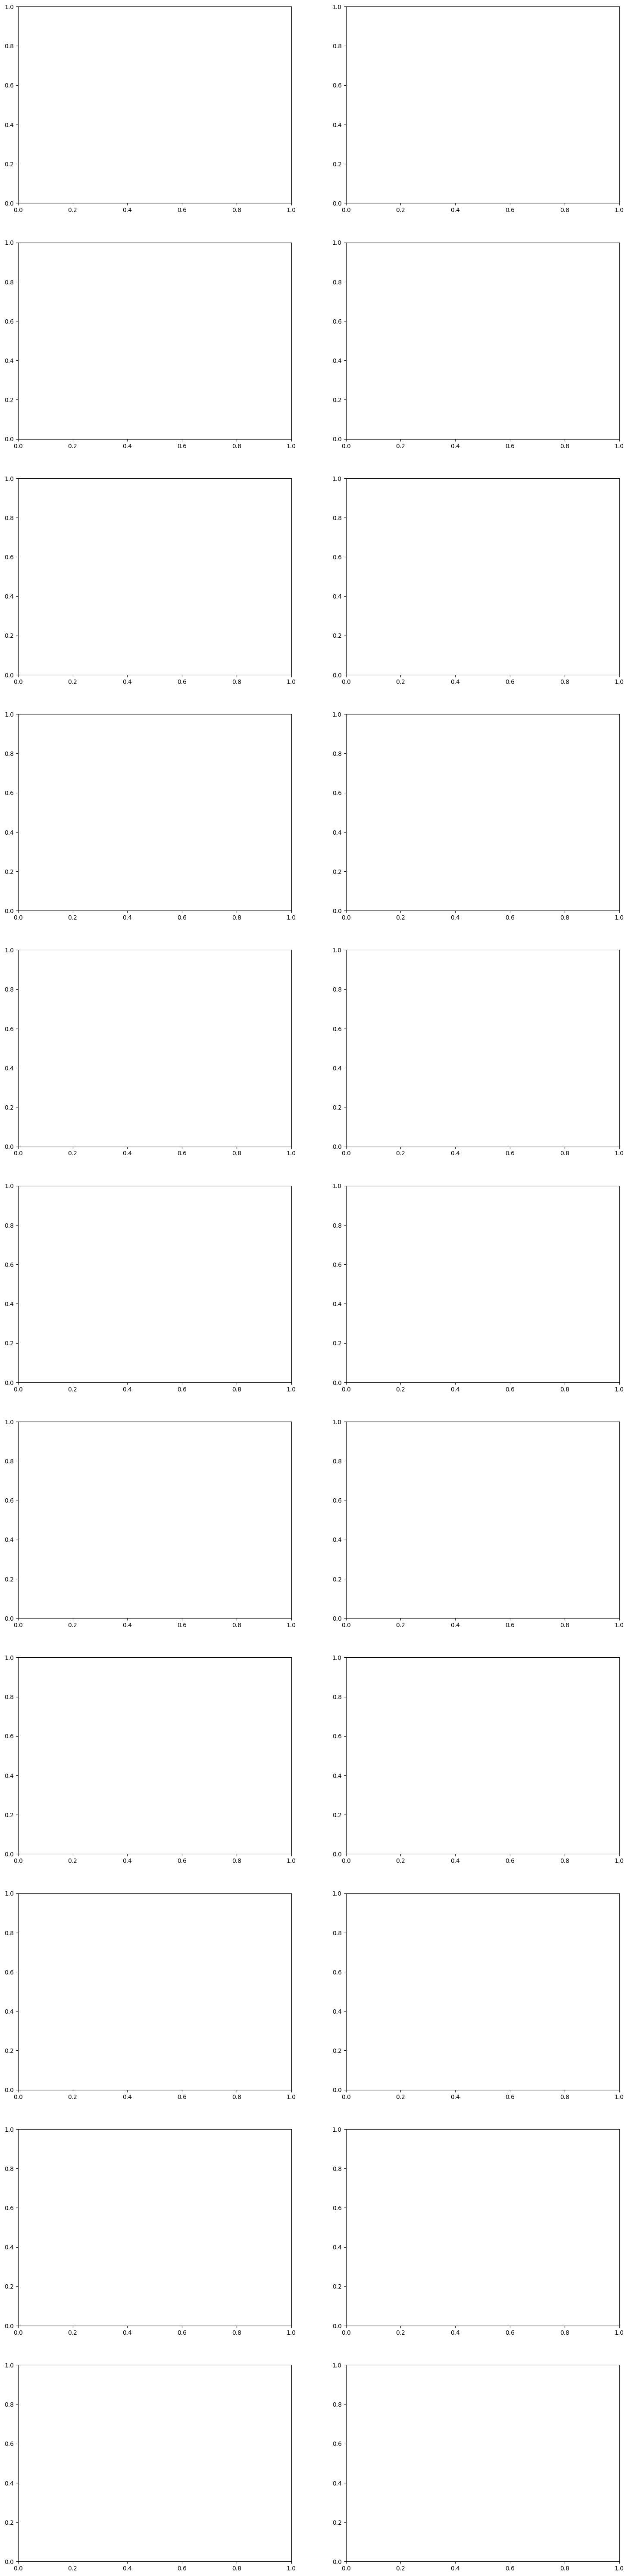

In [ ]:
# os.makedirs('plots_umap_noise', exist_ok=True)
# plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], 'veh0_normal', noise=True, save_path='plots_umap_noise/carla_veh0_normal.png')
# plot_umap_uah_compare(carla, df_acc, ['acc_x', 'acc_y'], 'veh1_aggressive', noise=True, save_path='plots_umap_noise/carla_veh1_aggressive.png')